In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

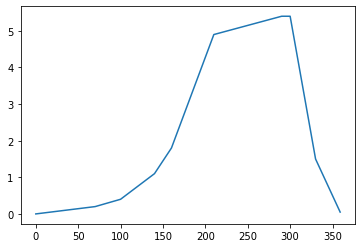

In [2]:
X = [0,70, 100, 140, 160,210, 290, 300, 330, 360]
Y = [0, 0.2, 0.4, 1.1,1.8,  4.9, 5.4, 5.4, 1.5, 0]
x = np.arange(max(X))
lai = np.interp(x, X,Y)
plt.plot(lai)


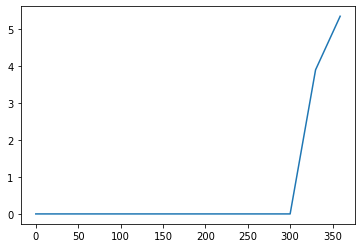

In [3]:
max_lai_index = 290
sai = [(max(lai) - L if i > max_lai_index else 0) for i, L in enumerate(lai)]
plt.plot(sai)


In [4]:
dd_daily = list(range(len(lai)))

In [5]:
nL = 6
nP = 3
max_lai_per_layer = 2

In [6]:
layers_lai = np.zeros((nL, len(lai)))
for iL in range(nL):
    for i, L in enumerate(lai):
        # print(min(L, max_lai_per_layer))
        if iL == 0:
            layers_lai[int(iL),i] = min(L, max_lai_per_layer)
        else:
            sum_prev_layers = sum(layers_lai[0:int(iL-1),i])
            layers_lai[int(iL),i] = min(max(0,L-sum_prev_layers), max_lai_per_layer)

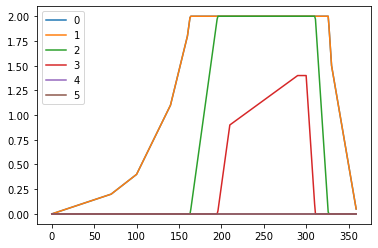

In [7]:
for iL in range(nL):
    plt.plot(layers_lai[iL], label=iL)
plt.legend()

In [8]:
from do3se_met.irradiance import calc_photoperiod

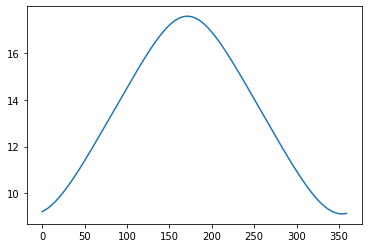

In [9]:
lat = 50
pr_full = np.array([calc_photoperiod(dd, lat=lat) for dd in dd_daily])
plt.plot(pr_full)

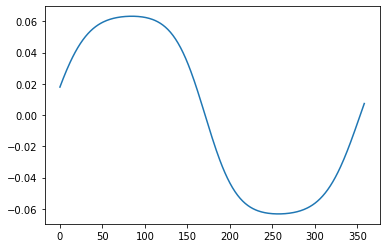

In [10]:
pr_diff_full = [b-a for a, b in zip(pr_full, pr_full[1:])]
plt.plot(pr_diff_full)

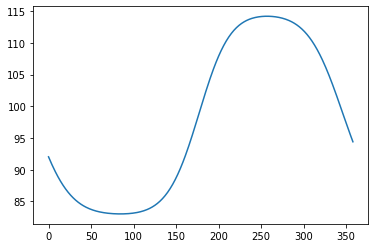

In [11]:
calc_phyllochron = lambda pr_dff: 1 / (0.0104 + 0.026 * pr_dff)
phyllochron_full = np.array([calc_phyllochron(df) for df in pr_diff_full])
rate_of_leaf_emergence = 1/phyllochron_full

plt.plot(phyllochron_full)

In [12]:
from itertools import accumulate

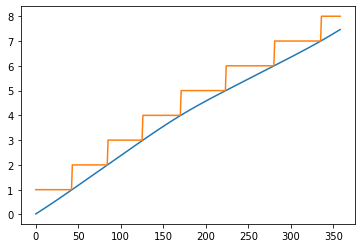

In [13]:
emergence_acc = np.array(list(accumulate(rate_of_leaf_emergence*2)))
emerged_leaf_count = np.ceil(emergence_acc)
plt.plot(emergence_acc)
plt.plot(emerged_leaf_count)

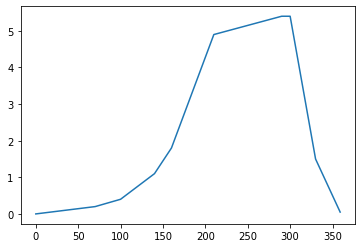

In [14]:
plt.plot(lai)

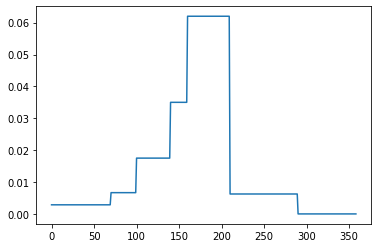

In [15]:
leaf_carbon = [max(0, b - a) for a, b in zip(lai, lai[1:])]
plt.plot(leaf_carbon)

In [16]:
max_lai_per_pop=2

In [17]:
def leaf_pop_is_growing(prev_leaf_lai, max_leaf_lai, total_emerged_leaves, prev_layer_growing):
    if prev_leaf_lai > max_leaf_lai:
        return False
    if sum(prev_layer_growing) >= total_emerged_leaves:
        return False
    return True

In [18]:
leaf_pops_lai = np.zeros((nP,nL, len(lai)))

In [19]:
def get_growing_populations(total_emerged_leaves, max_leaf_lai, prev_leaf_lais):
    total_growing_populations = 0
    growing_populations = [False for _ in range(nP)]
    for i, iP in enumerate(range(nP)):
        prev_leaf_lai = prev_leaf_lais[iP]
        is_growing = True
        if prev_leaf_lai >= max_leaf_lai:
            is_growing=False
        if i >= total_emerged_leaves:
        # if sum(growing_populations[0:iP]) >= total_emerged_leaves:
            is_growing=False

        if is_growing:
            total_growing_populations += 1
            growing_populations[iP] = True
        
    return growing_populations

i = 0
prev_leaf_lais = [sum(leaf_pops_lai[iP,:, i-1]) for iP in range(nP)]
total_emerged_leaves = emerged_leaf_count[i]
get_growing_populations(total_emerged_leaves, max_lai_per_pop,prev_leaf_lais)

        

        


[True, False, False]

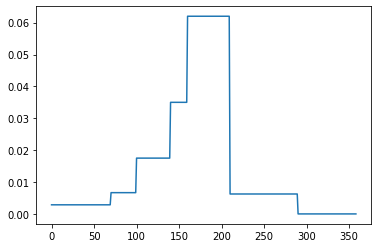

In [20]:
plt.plot(leaf_carbon)

In [21]:
# layers_lai[1,:]

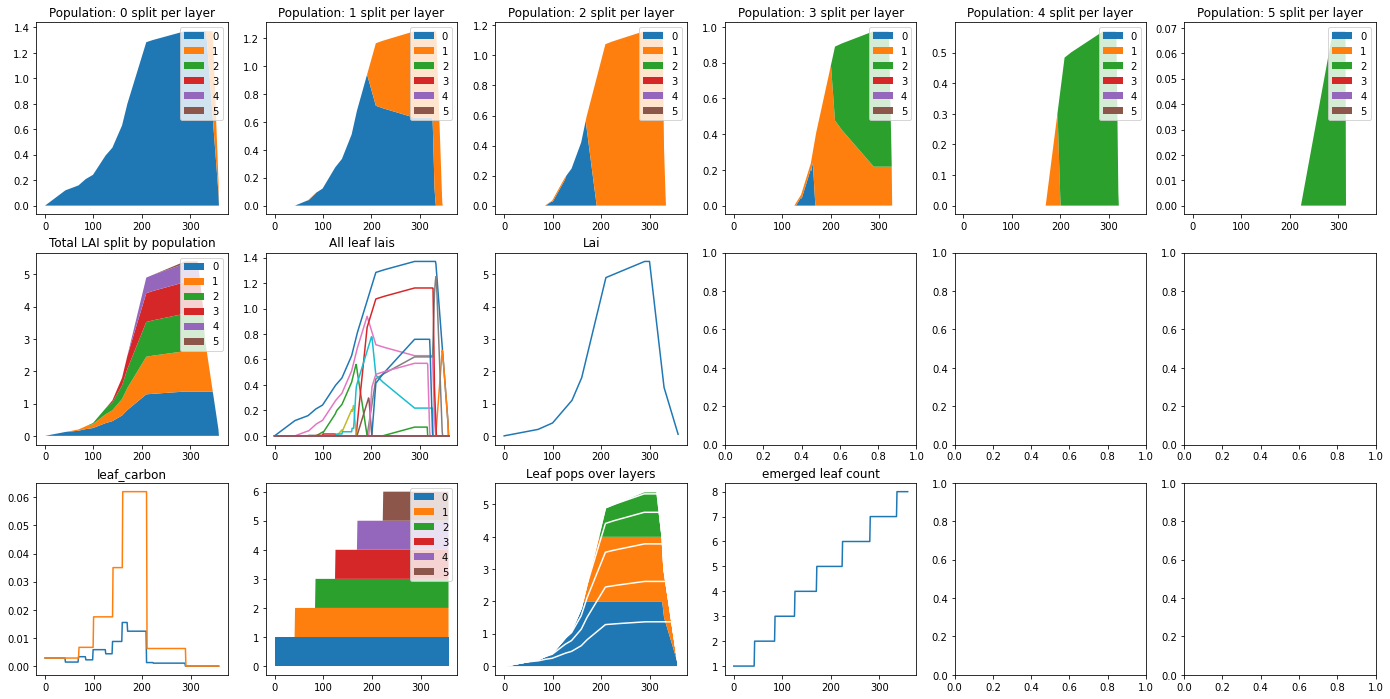

In [22]:
growing_tracker = []
max_lai_per_pop=2
c_leaf_per_pop_list = []
nP = 6
leaf_pops_lai = np.zeros((nP,nL, len(lai)))

# ==== RUN
for i, dd in enumerate(dd_daily):
    if i ==0:
        continue # skip first row
    if i == 359:
        continue
    # 1. Find growing leaf count
    prev_leaf_lais = [sum(leaf_pops_lai[iP,:, i-1]) for iP in range(nP)]
    total_emerged_leaves = emerged_leaf_count[i]
    growing_populations = get_growing_populations(total_emerged_leaves, max_lai_per_pop,prev_leaf_lais)
    growing_tracker.append(growing_populations)
    c_leaf = leaf_carbon[i]
    total_growing_populations = sum(growing_populations)
    c_leaf_per_pop = c_leaf/total_growing_populations if total_growing_populations > 0 else 0
    c_leaf_per_pop_list.append(c_leaf_per_pop)
    
    remaining_layer_lai = layers_lai[:,i].copy()

    for iP in range(nP):
        prev_leaf_lai = prev_leaf_lais[iP]
        is_growing = growing_populations[iP]
        new_leaf_lai = prev_leaf_lai + c_leaf_per_pop if is_growing else prev_leaf_lai
        # leaf_pops_lai[iP, 0, i] = new_leaf_lai

        # Split between layers
        remaining_leaf_lai = new_leaf_lai    
        for iL in range(nL):
            layer_lai = remaining_layer_lai[iL]

            if layer_lai > 0:
                f_p_in_layer = min(1, max(0, remaining_leaf_lai/remaining_layer_lai[iL]))
                p_in_layer = remaining_layer_lai[iL] * f_p_in_layer
                remaining_layer_lai[iL] -= p_in_layer
                remaining_leaf_lai -= p_in_layer
                leaf_pops_lai[iP, iL, i] = p_in_layer

# === PLOT RESULTS =====
fig, axs = plt.subplots(ncols=nP, nrows=3, figsize=(24,12))
x = np.arange(len(lai))

axs[1][1].set_title("All leaf lais")
for iP in range(nP):
    a = sum(np.sum(leaf_pops_lai[0:iP,:,:],axis=1))
    b = np.sum(leaf_pops_lai[iP,:,:],axis=0)
    axs[1][0].fill_between(x, a, a + b, label=iP)
    axs[1][0].legend()
    axs[1][0].set_title("Total LAI split by population")
    for iL in range(nL):
        a = np.sum(leaf_pops_lai[iP,0:iL,:], axis=0)
        b = leaf_pops_lai[iP,iL,:]
        axs[0][iP].set_title(f"Population: {iP} split per layer")
        axs[0][iP].fill_between(x, a, a + b, label=iL)
        axs[0][iP].legend()
        axs[1][1].plot(leaf_pops_lai[iP,iL,:])
axs[2][0].plot(c_leaf_per_pop_list)
axs[2][0].plot(leaf_carbon)
axs[2][0].set_title("leaf_carbon")

for i, iP in enumerate(range(nP)):
    a = np.array([sum(a[0:iP]) for a in growing_tracker])
    b = np.array([a[iP] for a in growing_tracker])
    x = np.arange(len(a))
    axs[2][1].fill_between(x, i, i + b, label=iP)
    axs[2][1].legend()

axs[2][2].set_title("Leaf pops over layers")
for iL in range(nL):
    a = sum(np.sum(leaf_pops_lai[:,0:iL,:],axis=1))
    b = np.sum(leaf_pops_lai[:,iL,:],axis=0)
    x = np.arange(len(a))
    axs[2][2].fill_between(x, a, a + b)
for iP in range(nP):
    a = sum(np.sum(leaf_pops_lai[0:iP,:,:],axis=1))
    b = np.sum(leaf_pops_lai[iP,:,:],axis=0)
    axs[2][2].plot(a + b, label=iP, c="white")

axs[2][3].set_title("emerged leaf count")
axs[2][3].plot(emerged_leaf_count)

axs[1][2].set_title("Lai")
axs[1][2].plot(lai)


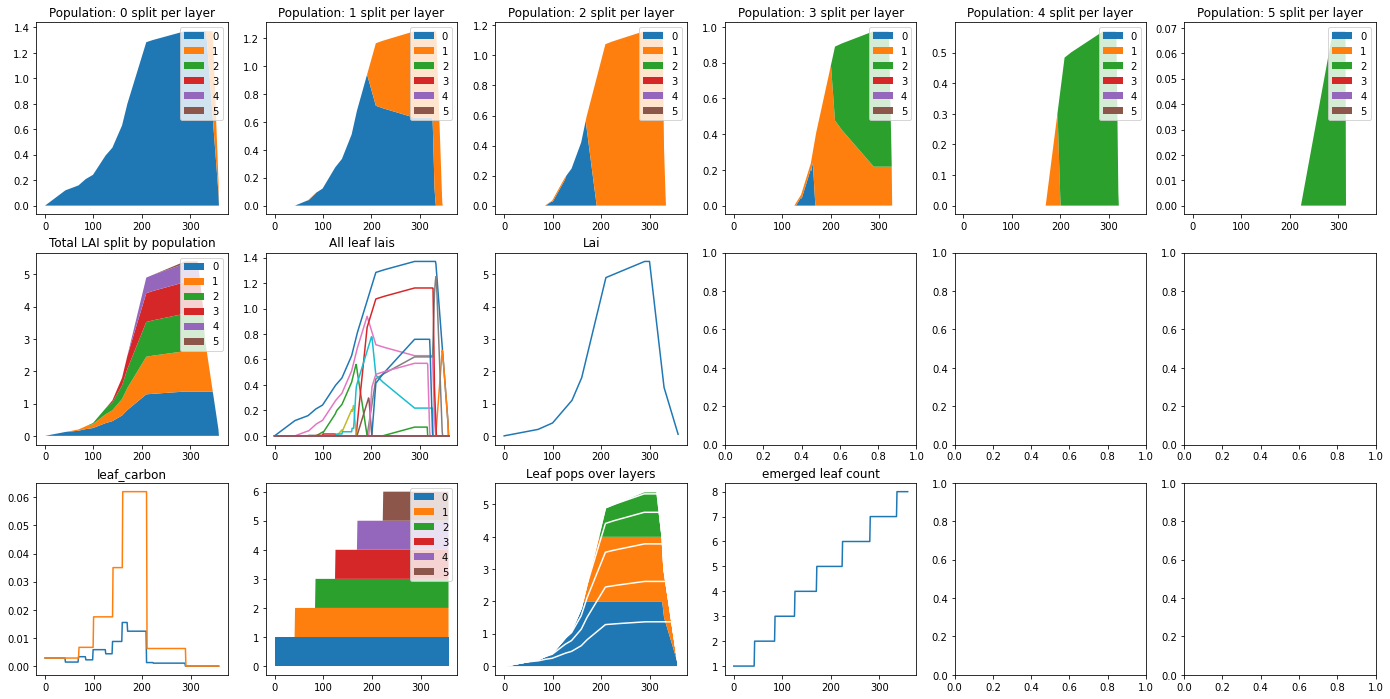

In [23]:
fig, axs = plt.subplots(ncols=nP, nrows=3, figsize=(24,12))
x = np.arange(len(lai))

axs[1][1].set_title("All leaf lais")
for iP in range(nP):
    a = sum(np.sum(leaf_pops_lai[0:iP,:,:],axis=1))
    b = np.sum(leaf_pops_lai[iP,:,:],axis=0)
    axs[1][0].fill_between(x, a, a + b, label=iP)
    axs[1][0].legend()
    axs[1][0].set_title("Total LAI split by population")
    for iL in range(nL):
        a = np.sum(leaf_pops_lai[iP,0:iL,:], axis=0)
        b = leaf_pops_lai[iP,iL,:]
        axs[0][iP].set_title(f"Population: {iP} split per layer")
        axs[0][iP].fill_between(x, a, a + b, label=iL)
        axs[0][iP].legend()
        axs[1][1].plot(leaf_pops_lai[iP,iL,:])
axs[2][0].plot(c_leaf_per_pop_list)
axs[2][0].plot(leaf_carbon)
axs[2][0].set_title("leaf_carbon")

for i, iP in enumerate(range(nP)):
    a = np.array([sum(a[0:iP]) for a in growing_tracker])
    b = np.array([a[iP] for a in growing_tracker])
    x = np.arange(len(a))
    axs[2][1].fill_between(x, i, i + b, label=iP)
    axs[2][1].legend()

axs[2][2].set_title("Leaf pops over layers")
for iL in range(nL):
    a = sum(np.sum(leaf_pops_lai[:,0:iL,:],axis=1))
    b = np.sum(leaf_pops_lai[:,iL,:],axis=0)
    x = np.arange(len(a))
    axs[2][2].fill_between(x, a, a + b)
for iP in range(nP):
    a = sum(np.sum(leaf_pops_lai[0:iP,:,:],axis=1))
    b = np.sum(leaf_pops_lai[iP,:,:],axis=0)
    axs[2][2].plot(a + b, label=iP, c="white")

axs[2][3].set_title("emerged leaf count")
axs[2][3].plot(emerged_leaf_count)

axs[1][2].set_title("Lai")
axs[1][2].plot(lai)


In [24]:
growing_tracker[0]

[True, False, False, False, False, False]

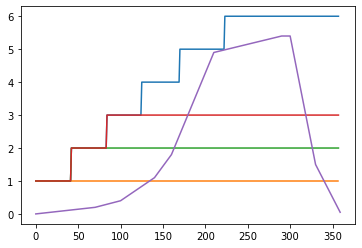

In [25]:
plt.plot([sum(a) for a in growing_tracker])
plt.plot([a[0] for a in growing_tracker])
plt.plot([a[1] + a[0] for a in growing_tracker])
plt.plot([a[2] + a[1] + a[0] for a in growing_tracker])
plt.plot(lai)

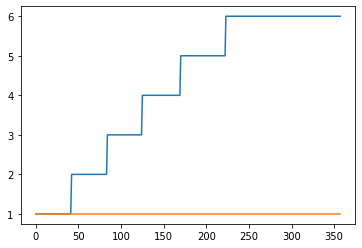

In [26]:
plt.plot([sum(a) for a in growing_tracker])
plt.plot([a[0] for a in growing_tracker])

In [27]:
np.sum(np.ones((3,4,5)).reshape(3*4,5), axis=0)

array([12., 12., 12., 12., 12.])

# Single Hour calcs

In [28]:
from typing import List

In [29]:

def get_growing_populations(
    total_emerged_leaves: int,
    max_leaf_lai: float,
    prev_leaf_lais: List[float],
    nP: int,
) -> List[bool]:
    """Get a boolean list of growing leaf populations.

    Parameters
    ----------
    total_emerged_leaves : int
        then number of leaf populations that have emerged
    max_leaf_lai : float
        The maximum lai per leaf population
    prev_leaf_lais : List[float]
        previous hour leaf population lai
    nP : int
        number of leaf populations

    Returns
    -------
    List[bool]
        Boolean list of growing leaf populations (True if growing)

    """
    total_growing_populations = 0
    growing_populations = [False for _ in range(nP)]
    for i, iP in enumerate(range(nP)):
        prev_leaf_lai = prev_leaf_lais[iP]
        is_growing = True
        if prev_leaf_lai >= max_leaf_lai:
            is_growing = False
        if i >= total_emerged_leaves:
            is_growing = False

        if is_growing:
            total_growing_populations += 1
            growing_populations[iP] = True

    return growing_populations


LeafPopShape = List[List[float]]  # numpy array


def calc_leaf_pops_per_layer(
    prev_leaf_pops_per_lai: LeafPopShape,  # numpy array
    total_emerged_leaves: int,
    total_leaf_carbon: float,
    layers_lai: List[float],
    nP: int,
    nL: int,
    max_lai_per_pop: float,
) -> LeafPopShape:
    """Calculate the lai per leaf population per layer.

    Parameters
    ----------
    prev_leaf_pops_per_lai : LeafPopShape
        lai per leaf pop per layer
    total_leaf_carbon : float
        total leaf carbon
    layers_lai : List[float]
        layer current lai
    nP : int
        Number of leaf populations
    nL : int
        Number of layers
    max_lai_per_pop : float
        maximum lai per leaf population

    Returns
    -------
    LeafPopShape
        lai per leaf pop per layer

    """
    prev_leaf_lais = [sum(prev_leaf_pops_per_lai[iP, :])
                      for iP in range(nP)]  # sum of population over all layers
    growing_populations = get_growing_populations(
        total_emerged_leaves, max_lai_per_pop, prev_leaf_lais, nP)
    c_leaf = total_leaf_carbon
    total_growing_populations = sum(growing_populations)
    # TODO: Should we convert this to LAI?
    c_leaf_per_pop = c_leaf / total_growing_populations if total_growing_populations > 0 else 0

    remaining_layer_lai = layers_lai.copy()
    leaf_pop_per_layer = np.zeros((nP, nL))
    for iP in range(nP):
        prev_leaf_lai = prev_leaf_lais[iP]
        is_growing = growing_populations[iP]
        new_leaf_lai = prev_leaf_lai + c_leaf_per_pop if is_growing else prev_leaf_lai

        # Split between layers
        remaining_leaf_lai = new_leaf_lai
        for iL in range(nL):
            layer_lai = remaining_layer_lai[iL]

            if layer_lai > 0:
                f_p_in_layer = min(1, max(0, remaining_leaf_lai / layer_lai))
                p_in_layer = layer_lai * f_p_in_layer
                remaining_layer_lai[iL] -= p_in_layer
                remaining_leaf_lai -= p_in_layer
                leaf_pop_per_layer[iP, iL] = p_in_layer

    return leaf_pop_per_layer


In [30]:
calc_leaf_pops_per_layer(
    np.array([[1,1,1],[0,0,0],[0,0,0]]),
    2,
    0.2,
    [1,1,1],
    3,
    3,
    0.5,
) 

array([[1., 1., 1.],
       [0., 0., 0.],
       [0., 0., 0.]])